# Error Bar Illustration

In [2]:
from datetime import datetime
from matplotlib import pylab as plt
import pandas as pd
import seaborn as sns

sns.set()

In [3]:
df_dataset = pd.read_csv('../data/processed/method2/k35/delta_window4/processed_daysahead3_R000.csv', index_col='current_time')
df_dataset.index = pd.to_datetime(df_dataset.index)

for col in df_dataset.columns:
    if 'time' in col:
        df_dataset[col] = pd.to_datetime(df_dataset[col])

df_dataset.head()

,forward_time,forward_Vp_pred,forward_Vp_obs,forward_sigma,forward_crps
current_time,,,,,
2010-01-04 18:00:00,2010-01-07 12:00:00,302.650000,286.61,96.238650,23.554548
2010-01-05 00:00:00,2010-01-07 18:00:00,306.100000,283.42,84.650720,22.192234
2010-01-05 06:00:00,2010-01-08 00:00:00,317.327273,309.38,98.268001,23.221008
2010-01-05 12:00:00,2010-01-08 06:00:00,328.554545,274.53,96.180768,34.274529
2010-01-05 18:00:00,2010-01-08 12:00:00,320.569697,280.69,91.876971,28.270464


In [4]:

df_obs = pd.read_csv('../data/ace_hr.dat', sep="\\s+", comment="#")
df_obs = df_obs[df_obs.year >= df_dataset.index.min().year]
df_obs = df_obs[df_obs.year <= df_dataset.index.max().year]
df_obs.index = [
    datetime(int(row.year), int(row.month), int(row.day), int(row.hour))
    for _, row in df_obs.iterrows()
]


In [5]:
df_obs.head()

,juldate,month,day,hour,year,doy,Vp_obs,Br_obs,imf_obs,Np_obs,beta_obs
2010-01-01 00:00:00,15197.50,1,1,0,2010,1,276.62,0.09,1.0,0.0,0.0
2010-01-01 01:00:00,15197.54,1,1,1,2010,1,271.82,0.63,1.0,0.0,0.0
2010-01-01 02:00:00,15197.58,1,1,2,2010,1,273.09,0.58,1.0,0.0,0.0
2010-01-01 03:00:00,15197.62,1,1,3,2010,1,278.73,-0.05,-1.0,0.0,0.0
2010-01-01 04:00:00,15197.67,1,1,4,2010,1,271.79,0.11,1.0,0.0,0.0


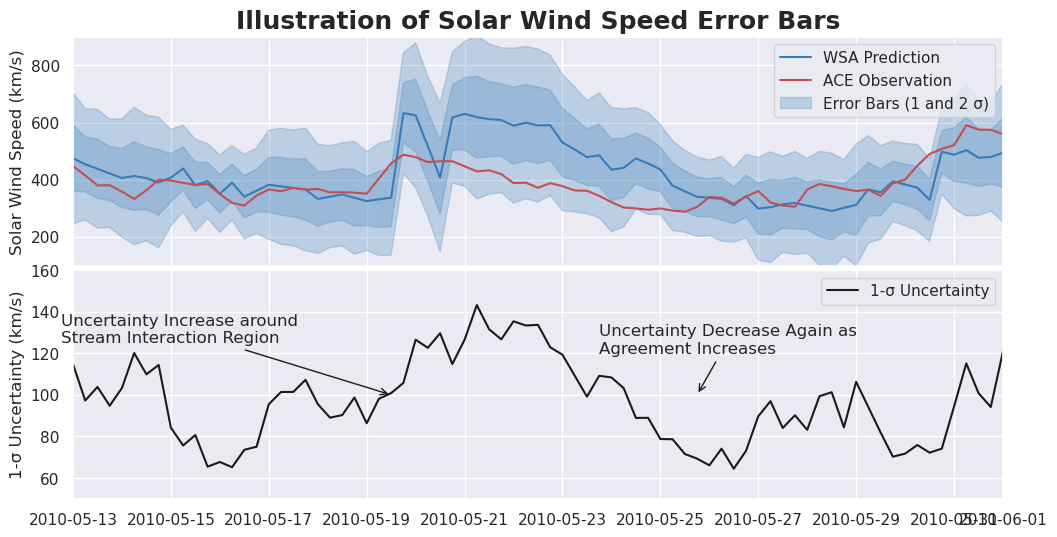

In [11]:
blue_color = '#367cb9'
red_color = 'r'
black_color= 'k'
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

time_col = 'forward_time'
pred_col = 'forward_Vp_pred'
obs_col = 'forward_Vp_obs'
sigma_col = 'forward_sigma'

ax = axes[0]
ax.plot(df_dataset[time_col], df_dataset[pred_col], color=blue_color, label='WSA Prediction')
ax.plot(df_dataset[time_col], df_dataset[obs_col], color=red_color, label='ACE Observation')
ax.fill_between(df_dataset[time_col], df_dataset[pred_col] - df_dataset[sigma_col], df_dataset[pred_col] + df_dataset[sigma_col], alpha=0.25, color=blue_color, label='Error Bars (1 and 2 σ)')
ax.fill_between(df_dataset[time_col], df_dataset[pred_col] - 2 * df_dataset[sigma_col], df_dataset[pred_col] + 2 * df_dataset[sigma_col], alpha=0.25, color=blue_color)
ax.set_ylabel('Solar Wind Speed (km/s)')
ax.set_yticks([200, 400, 600, 800])
ax.set_ylim(100, 900)

ax = axes[1]
ax.plot(df_dataset[time_col], df_dataset[sigma_col], color=black_color, label='1-σ Uncertainty')
ax.set_ylabel('1-σ Uncertainty (km/s)')
ax.set_ylim(50, 160)
#ax.set_yticks([75, 100, 125])

ax.annotate("Uncertainty Decrease Again as\nAgreement Increases",
            xytext=(pd.Timestamp('2010-05-23 18:00:00'), 120),
            xy=(pd.Timestamp('2010-05-25 18:00:00'), 100),
            arrowprops=dict(arrowstyle="->", color='k'))

ax.annotate("Uncertainty Increase around\nStream Interaction Region",
            xytext=(pd.Timestamp('2010-05-12 18:00:00'), 125),
            xy=(pd.Timestamp('2010-05-19 12:00:00'), 100),
            arrowprops=dict(arrowstyle="->", color='k'))

for ax in axes:
    ax.legend()

#i = 500
#print(repr((df_dataset.index[i], df_dataset.index[i + 100])))
#    ax.set_xlim(df_dataset.index[i], df_dataset.index[i + 100])

#plt.xlim(pd.Timestamp('2010-02-25 18:00:00'), pd.Timestamp('2010-03-22 18:00:00'))
axes[0].set_xlim((pd.Timestamp('2010-05-13 0:00:00'), pd.Timestamp('2010-06-01 00:00:00')))
axes[0].set_title('Illustration of Solar Wind Speed Error Bars', fontweight='bold', fontsize=18)
plt.subplots_adjust(wspace=0.4, hspace=0.02) 
plt.savefig('../plots/error_bar_illustration.png', dpi=300)